# dl

> Deep learning based operators

In [ ]:
#| default_exp cli/dl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging
import zarr
import numpy as np
from numba import prange
from pathlib import Path
import math
import cmath
import importlib
import onnxruntime
from moraine.utils_ import ngjit, ngpjit

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
from moraine.chunk_ import chunkwise_slicing_mapping
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
import moraine.cli as mc
from moraine.cli.logging import mc_logger
from moraine.cli import mk_clean_dir, dask_from_zarr, dask_from_zarr_overlap, dask_to_zarr

In [ ]:
#| export
def _ort_session(
    path:str, # path to the model in onnx format
    cuda:bool=False, # if use cuda or not
):
    if cuda:
        providers = [("CUDAExecutionProvider", {"device_id": cp.cuda.runtime.getDevice()}),'CPUExecutionProvider']
    else:
        providers = ['CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(path, providers=providers)
    return ort_session

In [ ]:
#| export
@ngpjit
def _cli_pre_infer_n2f_numba(
    ref, # reference rslc
    sec, # secoundary rslc
):
    nlines, width = ref.shape
    out = np.empty((1,2,nlines,width),dtype=np.float32)
    mask = np.empty((nlines,width),dtype=np.bool_)
    for i in prange(nlines):
        for j in prange(width):
            intf_i_j = ref[i,j]*sec[i,j].conjugate()
            if math.isnan(intf_i_j.real):
                mask[i,j] = True
                random_phase = np.random.uniform(-math.pi,math.pi)
                out[0,0,i,j] = math.cos(random_phase)
                out[0,1,i,j] = math.sin(random_phase)
            else:
                mask[i,j] = False
                amp = abs(intf_i_j)
                out[0,0,i,j] = intf_i_j.real/amp
                out[0,1,i,j] = intf_i_j.imag/amp
    return out, mask

In [ ]:
#| export
if is_cuda_available():
    _cli_pre_infer_n2f_kernel = cp.ElementwiseKernel(
            'raw T ref_, raw T sec_, int32 nlines, int32 width',
            'raw float32 out, raw bool mask',
            '''
            int npixels = nlines*width;
            if (i >= npixels) return;

            T intf_i = ref_[i]*conj(sec_[i]);
            if (isnan(intf_i.real())){
                mask[i] = true;
            }
            else{
                mask[i] = false;
                float amp = abs(intf_i);
                out[i] = intf_i.real()/amp;
                out[npixels+i] = intf_i.imag()/amp;
            }
            ''',
            #preamble = '#include "curand.h"',
            # I do not find an easy way to generate random number with cupy kernel
            name = 'cli_pre_infer_n2f_kernel',reduce_dims=False,no_return=True)

In [ ]:
#| export
if is_cuda_available():
    def _cli_pre_infer_n2f_cp(ref,sec):
        nlines, width = ref.shape
        out = cp.empty((1,2,nlines,width),dtype=cp.float32)
        mask = cp.empty((nlines,width),dtype=bool)
        _cli_pre_infer_n2f_kernel(ref,sec,cp.int32(nlines),cp.int32(width),out,mask,size=nlines*width,block_size=128)

        nan_pos = cp.where(mask)
        random_phase = cp.random.uniform(-cp.pi,cp.pi,len(nan_pos[0]))
        out[0,0,nan_pos[0],nan_pos[1]] = cp.cos(random_phase)
        out[0,1,nan_pos[0],nan_pos[1]] = cp.sin(random_phase)
        return out, mask

In [ ]:
#| hide
rslc_zarr = zarr.open('../CLI/raw/rslc.zarr/','r')
ref = rslc_zarr[:,:,0]
sec = rslc_zarr[:,:,1]
test_img_complex = ref*sec.conj()

In [ ]:
#| hide
intf, mask = _cli_pre_infer_n2f_numba(ref,sec)
intf_ = test_img_complex*(1/abs(test_img_complex))
intf_ = np.stack((intf_.real,intf_.imag))[None,...]
np.testing.assert_array_almost_equal(intf[:,:,~mask],intf_[:,:,~mask])

In [ ]:
#| hide
if is_cuda_available():
    intf_cp, mask_cp = _cli_pre_infer_n2f_cp(cp.asarray(ref),cp.asarray(sec))
    np.testing.assert_array_almost_equal(intf[:,:,~mask],intf_cp[:,:,~mask_cp].get())
    np.testing.assert_array_equal(mask,mask_cp.get())

In [ ]:
#| export
def _cli_n2f_cpu(
    ref,
    sec,
    chunks:tuple=None, # chunksize, intf.shape by default 
    depths:tuple=(0,0), # width of the boundary
    model:str=None, # path to the model in onnx format, use the model comes with this package by default
):
    if model is None:
        model = importlib.resources.files('moraine')/'dl_model/n2f.onnx'
    shape = ref.shape
    if chunks is None: chunks = shape
    in_slices, out_slices, map_slices = chunkwise_slicing_mapping(shape,chunks,depths)
    out = np.empty_like(ref)
    
    session = mr.dl._ort_session(model,cuda=False)
    for in_slice, out_slice, map_slice in zip(in_slices, out_slices, map_slices):
        input_intf_slice, mask_slice = _cli_pre_infer_n2f_numba(ref[in_slice],sec[in_slice])
        infer_out_slice = session.run([session.get_outputs()[0].name,],{session.get_inputs()[0].name: input_intf_slice})[0]
        out[out_slice] = mr.dl._after_infer_n2f_numba(infer_out_slice,mask_slice)[map_slice]
    return out

In [ ]:
#| export
def _cli_n2f_np_in_gpu(
    ref,
    sec,
    chunks:tuple=None, # chunksize, intf.shape by default 
    depths:tuple=(0,0), # width of the boundary
    model:str=None, # path to the model in onnx format, use the model comes with this package by default
):
    if model is None:
        model = importlib.resources.files('moraine')/'dl_model/n2f.onnx'
    shape = ref.shape
    if chunks is None: chunks = shape
    in_slices, out_slices, map_slices = chunkwise_slicing_mapping(shape,chunks,depths)
    out = np.empty_like(ref)
    
    session = _ort_session(model,cuda=True)
    for in_slice, out_slice, map_slice in zip(in_slices, out_slices, map_slices):
        ref_slice = cp.asarray(ref[in_slice])
        sec_slice = cp.asarray(sec[in_slice])
        input_intf_slice, mask_slice = _cli_pre_infer_n2f_cp(ref_slice,sec_slice)
        
        input_intf_slice = cp.ascontiguousarray(input_intf_slice)
        output_intf_slice = cp.ascontiguousarray(cp.empty_like(input_intf_slice))
        io_binding = session.io_binding()
        io_binding.bind_input(
                name=session.get_inputs()[0].name,
                device_type='cuda',
                device_id=input_intf_slice.device.id,
                element_type=input_intf_slice.dtype,
                shape=list(input_intf_slice.shape),
                buffer_ptr=input_intf_slice.data.ptr,
        )
        io_binding.bind_output(
                name=session.get_outputs()[0].name,
                device_type='cuda',
                device_id=output_intf_slice.device.id,
                element_type=output_intf_slice.dtype,
                shape=list(output_intf_slice.shape),
                buffer_ptr=output_intf_slice.data.ptr,
        )
        io_binding.synchronize_inputs()
        session.run_with_iobinding(io_binding)
        out[out_slice] = (mr.dl._after_infer_n2f_cp(output_intf_slice,mask_slice)[map_slice]).get()
    return out

In [ ]:
rslc_zarr = zarr.open('../CLI/raw/rslc.zarr/','r')
ref_ = rslc_zarr[:,:,7]
sec_ = rslc_zarr[:,:,13]

In [ ]:
%%time
#filtered_intf = _cli_n2f_cpu(ref,sec,depths=(10,10))
filtered_intf = _cli_n2f_np_in_gpu(ref_,sec_,depths=(0,0))
#filtered_intf = _cli_n2f_np_in_gpu(ref,sec,chunks=(2000,2000),depths=(0,0))

CPU times: user 4.62 s, sys: 1.47 s, total: 6.09 s
Wall time: 6.43 s


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
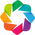

In [ ]:
import zarr
import numpy as np
import holoviews as hv
hv.extension('bokeh')
hv.output(widget_location='bottom')
from bokeh.models import WheelZoomTool
from holoviews import opts

In [ ]:
#| hide
filtered_intf_plot = mr.ras_plot(np.angle(filtered_intf))
filtered_intf_plot.opts(
    opts.Image(
        cmap='colorwheel',width=400, height=400, colorbar=True,invert_yaxis=True,
        default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
        active_tools=['wheel_zoom'])
)

:DynamicMap   []
   :Image   [x,y]   (z)

In [ ]:
#| export
@mc_logger
def n2f(
    rslc:str, # input: rslc stack, shape (nlines, width, nimages)
    intf:str, # output: filtered intfergrams stack, shape (nlines, width, )
    tnet:str=None, # input: temporal network
    chunks:tuple=None, # parallel processing azimuth/range chunk size, optional. Default: rslc.chunks[:2]
    out_chunks:tuple=None, # output chunks
    depths:tuple=(0,0), # width of the boundary
    model:str=None, # path to the model in onnx format, use the model comes with this package by default
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is True for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPUs for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 1 for cpu, only applied if cuda==False
    rmm_pool_size=0.5, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''Noise2Fringe interferogram filtering.
    '''
    rslc_path = rslc
    intf_path = intf
    logger = logging.getLogger(__name__)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path, rslc_zarr)
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."
    nlines, width, nimage = rslc_zarr.shape
    if chunks is None: chunks = rslc_zarr.chunks[:2]
    if out_chunks is None: out_chunks = rslc_zarr.chunks[:2]
    az_chunk, r_chunk = chunks
    logger.info(f'processing azimuth chunk size: {az_chunk}')
    logger.info(f'processing range chunk size: {r_chunk}')

    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
    else:
        if processes is None: processes = True
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 1
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)

    if tnet is not None:
        tnet = mr.TempNet.load(tnet)
    else:
        tnet = mr.TempNet.from_bandwidth(nimage)
    image_pairs = tnet.image_pairs
    n_image_pairs = image_pairs.shape[0]
    
    logger.info('starting dask cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda:
            client.run(cp.cuda.set_allocator, rmm_cupy_allocator)
            n2f_delayed = delayed(_cli_n2f_np_in_gpu,pure=True,nout=1)
        else:
            n2f_delayed = delayed(_cli_n2f_cpu,pure=True,nout=1)

        ref_cpu_rslc = dask_from_zarr(rslc_path, chunks=(*rslc_zarr.shape[0:2],1))
        # use two different rslc to make dask do not hold too much data 
        sec_cpu_rslc = dask_from_zarr(rslc_path, chunks=(*rslc_zarr.shape[0:2],1))
        logger.darr_info('rslc', ref_cpu_rslc)
        intf = np.empty((1,1,n_image_pairs),dtype=object)
        for i in range(n_image_pairs):
            ref_i, sec_i = image_pairs[i]
            intf[0,0,i] = n2f_delayed(ref_cpu_rslc[:,:,ref_i].to_delayed()[0,0],sec_cpu_rslc[:,:,sec_i].to_delayed()[0,0],chunks=chunks,depths=depths,model=model)
            intf[0,0,i] = da.from_delayed(intf[0,0,i],shape=rslc_zarr.shape[:2],meta=np.array((),dtype=ref_cpu_rslc.dtype)).reshape(*rslc_zarr.shape[:2],1)
        intf = da.block(intf.tolist())
        logger.info('got filtered interferograms.')
        logger.darr_info('intf', intf)

        logger.info('saving filtered interferograms.')
        _intf = dask_to_zarr(intf,intf_path,chunks=(*out_chunks,1))

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist([_intf,])
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
logger = mc.get_logger()

In [ ]:
rslc = './raw/rslc.zarr/'
intf = './dl/n2f_intf.zarr'
tnet_path = './dl/tnet.zarr'

In [ ]:
rslc_zarr = zarr.open(rslc,'r')
tnet = mr.TempNet.from_bandwidth(rslc_zarr.shape[-1], 1)
tnet.save(tnet_path)

In [ ]:
%%time
n2f(rslc,intf,tnet=tnet_path,chunks=(2500,1834))

2025-03-28 22:35:14 - log_args - INFO - running function: n2f
2025-03-28 22:35:14 - log_args - INFO - fetching args:
2025-03-28 22:35:14 - log_args - INFO - rslc = './raw/rslc.zarr/'
2025-03-28 22:35:14 - log_args - INFO - intf = './dl/n2f_intf.zarr'
2025-03-28 22:35:14 - log_args - INFO - tnet = './dl/tnet.zarr'
2025-03-28 22:35:14 - log_args - INFO - chunks = (2500, 1834)
2025-03-28 22:35:14 - log_args - INFO - out_chunks = None
2025-03-28 22:35:14 - log_args - INFO - depths = (0, 0)
2025-03-28 22:35:14 - log_args - INFO - model = None
2025-03-28 22:35:14 - log_args - INFO - cuda = False
2025-03-28 22:35:14 - log_args - INFO - processes = None
2025-03-28 22:35:14 - log_args - INFO - n_workers = None
2025-03-28 22:35:14 - log_args - INFO - threads_per_worker = None
2025-03-28 22:35:14 - log_args - INFO - rmm_pool_size = 0.5
2025-03-28 22:35:14 - log_args - INFO - dask_cluster_arg = {}
2025-03-28 22:35:14 - log_args - INFO - fetching args done.
2025-03-28 22:35:14 - zarr_info - INFO - 

In [ ]:
#| hide
# %%time
## in this notebook, n2f cli use cuda fails(because dask cuda fails), but out of this notebook, no problem. I don't know why.
# if is_cuda_available():
#     n2f(rslc,intf,tnet=tnet_path,chunks=(2500,1834),cuda=True)

In [ ]:
#| hide
filtered_intf_plot = mr.ras_plot(np.angle(zarr.open(intf,'r')[:,:,3]))
filtered_intf_plot.opts(
    opts.Image(
        cmap='colorwheel',width=400, height=400, colorbar=True,invert_yaxis=True,
        default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
        active_tools=['wheel_zoom'])
)

:DynamicMap   []
   :Image   [x,y]   (z)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()